# Classification Random Forest Model

In [24]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble  import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance


import pickle


In [25]:
# Import dataframe

df0 = pd.read_pickle('../../Data/Processed/abc_classification_modelling.p')
df0.head()

,customer_id,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,524,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,607,1,4.45,F,0.49,1279.91,183,22,5,58.177727
3,343,0,0.91,M,0.54,967.14,102,17,5,56.890588
4,322,1,3.02,F,0.63,1566.35,182,30,5,52.211667


In [26]:
# Remove non desired data from model (Non predictor data or ethics concern)
df1 = df0.drop(['customer_id'], axis=1)

In [27]:
# Shuffle data
df2 = shuffle(df1, random_state=42)

In [28]:
# Class balance 
df2['signup_flag'].value_counts(normalize=True)

signup_flag
0    0.689535
1    0.310465
Name: proportion, dtype: float64

In [29]:
# Deal with missing values
df2.isna().sum()

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [30]:
# Low value count for missing data so we drop
df3 = df2.dropna()

In [31]:
df3.head()

,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
714,0,1.64,M,0.58,27.81,6,3,3,9.270000
605,0,0.88,M,0.63,26.62,9,3,2,8.873333
120,0,0.56,M,0.62,886.78,154,18,4,49.265556
208,0,0.11,M,0.58,1256.19,168,34,5,36.946765
380,0,1.32,M,0.36,739.67,110,21,3,35.222381


In [32]:
# Split into input 'X' and output 'y'
X = df3.drop(['signup_flag'], axis = 1)
y = df3['signup_flag']

In [33]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y
                                                    )

In [34]:
categorical_vars = ['gender']

one_hot_encoder = OneHotEncoder(sparse_output = False, drop = 'first')

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis = 1)
X_train.drop(categorical_vars, axis=1, inplace=True)

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis = 1)
X_test.drop(categorical_vars, axis=1, inplace=True)

In [35]:
X_train.head(1)

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,1.22,0.6,636.51,123,22,5,28.932273,0.0


In [36]:
X_test.head(1)

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
0,1.92,0.64,1283.76,191,30,5,42.792,0.0


In [37]:
# Build model
clf = RandomForestClassifier(random_state = 42,
                             n_estimators = 500,
                             max_features = 5
                             )

In [38]:
# fit model
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=5, n_estimators=500, random_state=42)

In [39]:
y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1] # Return probability that the customer signed up

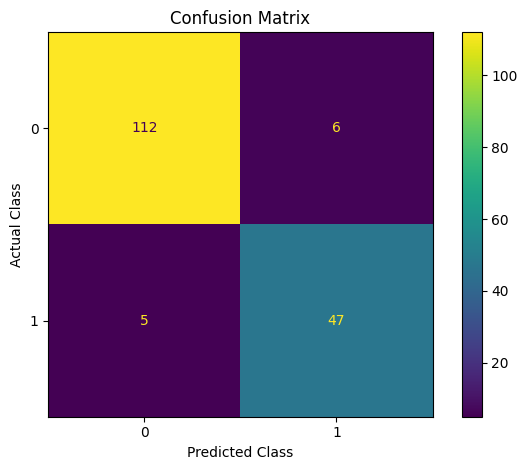

In [40]:
cm = confusion_matrix(y_test,
                      y_pred_class,
                      labels = clf.classes_
                      )

disp = ConfusionMatrixDisplay(confusion_matrix= cm,
                              display_labels = clf.classes_
                              )

disp.plot()
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


Calculated classification metrics

In [41]:
# Accuracy: number of correct classifications out of all attempted classifications
accuracy_score(y_test, y_pred_class)

0.9352941176470588

In [42]:
# Precision: Out of the predicted positive classifications, how many where right
precision_score(y_test, y_pred_class)

0.8867924528301887

In [43]:
# Recall: Out of the positive classifications, how many did we predict
recall_score(y_test, y_pred_class)

0.9038461538461539

In [44]:
# F1 : Harmonic mean of precision and recall
f1_score(y_test, y_pred_class)

0.8952380952380953

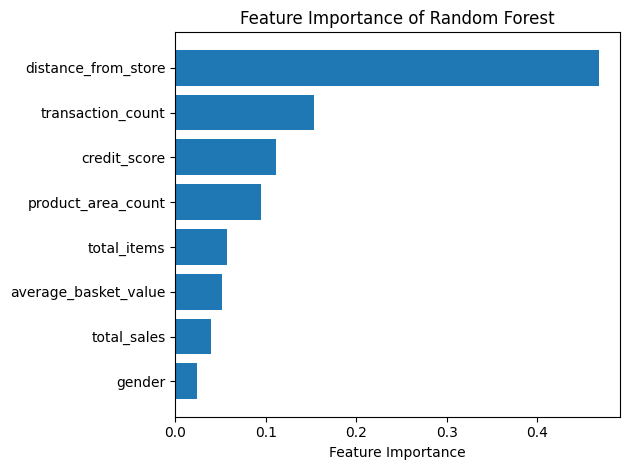

In [45]:
# Getting the feature importance metrics
# Based on gini importance

feature_importance = pd.DataFrame(clf.feature_importances_)
feature_names = pd.DataFrame(X.columns)
feature_importance_summary = pd.concat([feature_names,feature_importance],axis=1)
feature_importance_summary.columns = ['input_variable','feature_importance']
feature_importance_summary.sort_values(by='feature_importance',inplace=True)

plt.barh(feature_importance_summary['input_variable'],feature_importance_summary['feature_importance'])
plt.title('Feature Importance of Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

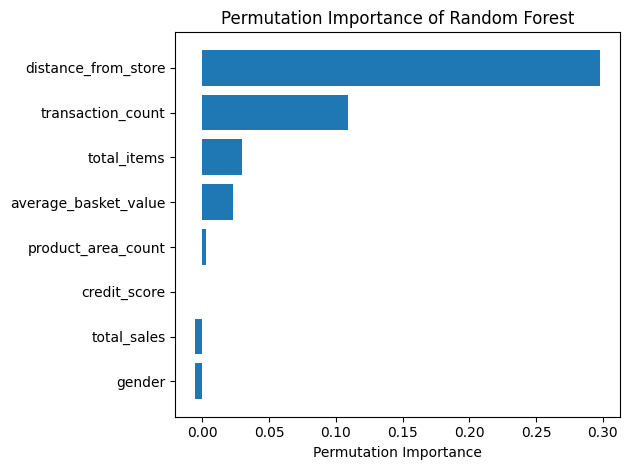

In [ ]:
# Permutation Importance
# Based on the decrease in accuracy when we randomise the values from the input variable
result = permutation_importance(clf, X_test, y_test, n_repeats = 10, random_state=42)

permutation_importance = pd.DataFrame(result['importances_mean'])
feature_names = pd.DataFrame(X.columns)
permutation_importance_summary = pd.concat([feature_names,permutation_importance],axis=1)
permutation_importance_summary.columns = ['input_variable','permutation_importance']
permutation_importance_summary.sort_values(by='permutation_importance',inplace=True)

plt.barh(permutation_importance_summary['input_variable'],permutation_importance_summary['permutation_importance'])
plt.title('Permutation Importance of Random Forest')
plt.xlabel('Permutation Importance')
plt.tight_layout()
plt.show()